## Calibration of model parameters (BLACK and SCHOLES, MERTON)
The **Implied Volatility** is that value $\\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
$$ BS(S, K, T, r, \sigma) = P  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.


In [2]:
from functions.MERTONpricer import Merton_pricer
from functions.BSpricer import BS_pricer
from functions.KOUpricer import Kou_pricer
from functions.VGpricer import VG_pricer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
import scipy.stats as ss
import scipy.optimize as scpo


Let's retrieve the historic prices for european call and put options starting from 2016-01-20 and expiring 1 year later.

In [3]:
df_call = pd.read_csv('data/options_spx_call_2016.csv')
df_put = pd.read_csv('data/options_spx_put_2016.csv')

df_call['C_Midpoint'] = abs(df_call['C_BID'] + df_call['C_ASK']) / 2
df_put['P_Midpoint'] = abs(df_put['P_BID'] + df_put['P_ASK']) / 2
df_call['C_Spread'] = df_call['C_BID'] - df_call['C_ASK']
df_put['P_Spread'] = df_put['P_BID'] - df_put['P_ASK']

q = 0       # dividend yield
r = 0.05     # risk-free interest rate
sigma = 0.2 #volatility (variance of diffusion process)
S0 = df_call.iloc[0]['UNDERLYING_LAST']
T = 1
call_strikes = df_call['STRIKE']    # array of K
put_strikes = df_put['STRIKE']
exercise = 'european'

call_prices = df_call['C_Midpoint']
put_prices = df_put['P_Midpoint']

Let's initialize an object of class BS_pricer which is able to find the theoretical price of the options, given the parameters.

In [4]:
BS = BS_pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=0.05, q = q, sigma=0.15, lambd=0.7, meanJ=-0.1, stdJ=0.1, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=0.15, lambd=0.5, p=0.4, eta1=10, eta2=5, exercise=exercise)
VG = VG_pricer(S0, K=None, ttm=T, r=r, q=q, sigma=0.15, theta=0.5, nu=0.08, exercise=exercise)

call_th_prices = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])

for i, K in enumerate(call_strikes):
    bs = BS.closed_formula_call(K)
    mert = Merton.closed_formula_call(K)
    kou = Kou.closed_formula_call(K)
    vg = VG.closed_formula_call(K)
    call_th_prices.loc[i] = [bs, mert, kou, vg]

print(f'Theoretical call options prices:')
print(call_th_prices)


Theoretical call options prices:
    BlackScholes      Merton         Kou  VarianceGamma
0     346.216485  345.099653  355.604762     352.647269
1     327.574374  325.828950  336.255804     333.900461
2     309.475546  307.042091  317.358849     315.619582
3     291.941230  288.767724  298.948078     297.825558
4     274.989921  271.033217  281.056622     280.538081
5     258.637221  253.864264  263.715936     263.775415
6     242.895724  237.284491  246.955207     247.554219
7     227.774952  221.315093  230.800800     231.889380
8     213.281349  205.974500  215.275774     216.793872
9     199.418307  191.278090  200.399469     202.278621
10    186.186247  177.237953  186.187197     188.352407
11    173.582728  163.862719  172.650015     175.021776
12    161.602596  151.157442  159.794614     162.290985
13    150.238150  139.123556  147.623292     150.161969
14    139.479344  127.758898  136.134036     138.634330
15    129.313992  117.057791  125.320678     127.705363
16    119.72799

PUT PRICES:

In [5]:
put_th_prices = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])

for i, K in enumerate(put_strikes):
    bs = BS.closed_formula_put(K)
    mert = Merton.closed_formula_put(K)
    kou = Kou.closed_formula_put(K)
    vg = VG.closed_formula_put(K)
    put_th_prices.loc[i] = [bs, mert, kou, vg]

print(f'Theoretical put options prices:')
print(put_th_prices)

Theoretical put options prices:
    BlackScholes      Merton         Kou  VarianceGamma
0      32.484300   31.367468   41.872577      38.915084
1      37.622925   35.877501   46.304354      43.949011
2      43.304832   40.871378   51.188135      49.448868
3      49.551252   46.377745   56.558100      55.435580
4      56.380678   52.423974   62.447379      61.928839
5      63.808714   59.035757   68.887429      68.946908
6      71.847952   66.236720   75.907436      76.506447
7      80.507916   74.048057   83.533765      84.622344
8      89.795048   82.488200   91.789474      93.307571
9      99.712742   91.572525  100.693905     102.573056
10    110.261418  101.313124  110.262368     112.427578
11    121.438635  111.718626  120.505922     122.877683
12    133.239238  122.794084  131.431256     133.927627
13    145.655528  134.540934  143.040670     145.579346
14    158.677458  146.957012  155.332149     157.832444
15    172.292841  160.036640  168.299527     170.684212
16    186.487576

In [6]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method, disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method == 'brent':
        x, res = scpo.brentq(obj_fun, a=1e-15, b=500, full_output=True)
        if res.converged:
            return x

    if method =='fsolve':
        #X0 = [0.03, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5, 1, 2]   # set of
        X0 = [0.1, 0.5, 1, 3]
        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if method == 'newton':
        guess = 0.5
        result = scpo.newton(obj_fun, guess, vega, tol=1e-4)
        return result


    if disp:
        return -1

Let's now compute the implied volatilities from the true market prices *call_prices*.

In [7]:
IV_BS = []; IV_M = []; IV_K = []; IV_VG = []

for i in range(len(call_prices)):
    IV_BS.append(implied_volatility(call_th_prices['BlackScholes'].values[i], S=S0, strike=call_strikes[i], t=T, rate=r,q=q, type_o='call', method='newton') )
    IV_M.append(implied_volatility(call_th_prices['Merton'].values[i], S=S0, strike = call_strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))
    IV_K.append(implied_volatility(call_th_prices['Kou'].values[i], S=S0, strike = call_strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))
    IV_VG.append(implied_volatility(call_th_prices['VarianceGamma'].values[i], S=S0, strike=call_strikes[i], t = T, rate=r, q=q, type_o='call', method='fsolve'))

imp_vol_call = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
imp_vol_call['BlackScholes'] = IV_BS
imp_vol_call['Merton'] = IV_M
imp_vol_call['Kou'] = IV_K
imp_vol_call['VarianceGamma'] = IV_VG

print(f'Implied volatilities found by each model for call options:\n{imp_vol_call}')

Implied volatilities found by each model for call options:
    BlackScholes    Merton       Kou  VarianceGamma
0            0.2  0.197443  0.220550       0.214237
1            0.2  0.196289  0.217810       0.213073
2            0.2  0.195166  0.215228       0.211919
3            0.2  0.194073  0.212805       0.210777
4            0.2  0.193013  0.210538       0.209645
5            0.2  0.191985  0.208425       0.208523
6            0.2  0.190990  0.206461       0.207411
7            0.2  0.190028  0.204643       0.206309
8            0.2  0.189098  0.202964       0.205217
9            0.2  0.188200  0.201419       0.204135
10           0.2  0.187335  0.200001       0.203062
11           0.2  0.186502  0.198705       0.201998
12           0.2  0.185699  0.197524       0.200943
13           0.2  0.184928  0.196453       0.199897
14           0.2  0.184186  0.195485       0.198860
15           0.2  0.183474  0.194616       0.197831
16           0.2  0.182789  0.193840       0.196812
17   

In [8]:
IV_BS = []; IV_M = []; IV_K = []; IV_VG = []

for i in range(len(put_prices)):
    IV_BS.append(implied_volatility(put_th_prices['BlackScholes'].values[i], S=S0, strike=put_strikes[i], t=T, rate=r, q=q, type_o='put', method='newton' ) )
    IV_M.append(implied_volatility(put_th_prices['Merton'].values[i], S=S0, strike = put_strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))
    IV_K.append(implied_volatility(put_th_prices['Kou'].values[i], S=S0, strike = put_strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))
    IV_VG.append(implied_volatility(put_th_prices['VarianceGamma'].values[i], S=S0, strike=put_strikes[i], t = T, rate=r, q=q, type_o='put', method='fsolve'))

imp_vol_put = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
imp_vol_put['BlackScholes'] = IV_BS
imp_vol_put['Merton'] = IV_M
imp_vol_put['Kou'] = IV_K
imp_vol_put['VarianceGamma'] = IV_VG

print(f'Implied volatilities found by each model for put options:\n {imp_vol_put}')

Implied volatilities found by each model for put options:
     BlackScholes    Merton       Kou  VarianceGamma
0            0.2  0.197443  0.220550       0.214237
1            0.2  0.196289  0.217810       0.213073
2            0.2  0.195166  0.215228       0.211919
3            0.2  0.194073  0.212805       0.210777
4            0.2  0.193013  0.210538       0.209645
5            0.2  0.191985  0.208425       0.208523
6            0.2  0.190990  0.206461       0.207411
7            0.2  0.190028  0.204643       0.206309
8            0.2  0.189098  0.202964       0.205217
9            0.2  0.188200  0.201419       0.204135
10           0.2  0.187335  0.200001       0.203062
11           0.2  0.186502  0.198705       0.201998
12           0.2  0.185699  0.197524       0.200943
13           0.2  0.184928  0.196453       0.199897
14           0.2  0.184186  0.195485       0.198860
15           0.2  0.183474  0.194616       0.197831
16           0.2  0.182789  0.193840       0.196812
17   

Plot of the implied volatilities with respect to the strike price.

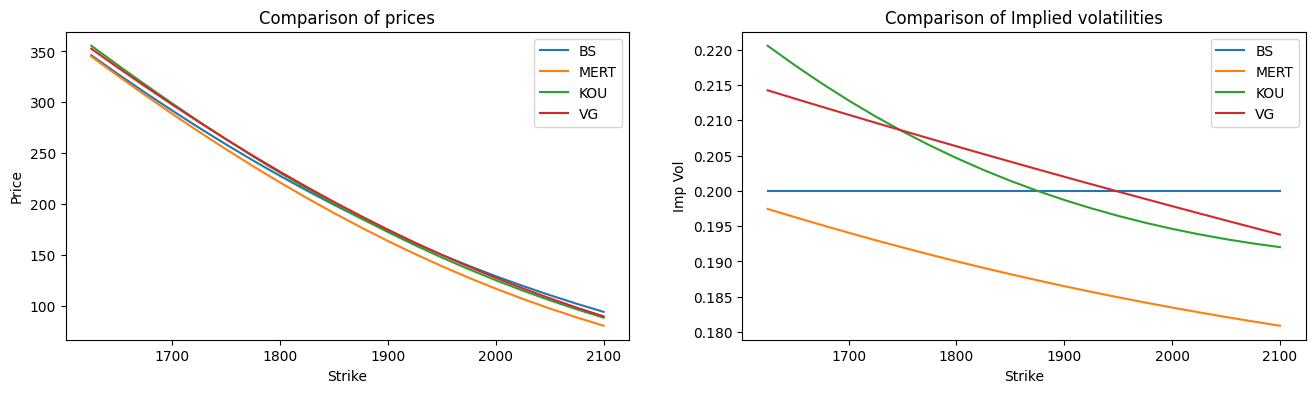

In [9]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(call_strikes, call_th_prices['BlackScholes'], label="BS"); ax1.plot(call_strikes, call_th_prices['Merton'], label="MERT")
ax1.plot(call_strikes, call_th_prices['Kou'], label="KOU"); ax1.plot(call_strikes, call_th_prices['VarianceGamma'], label="VG")
ax1.set_title("Comparison of prices"); ax1.set_xlabel("Strike"); ax1.set_ylabel("Price")

ax2.plot(call_strikes, imp_vol_call['BlackScholes'], label="BS"); ax2.plot(call_strikes, imp_vol_call['Merton'], label="MERT")
ax2.plot(call_strikes, imp_vol_call['Kou'], label="KOU"); ax2.plot(call_strikes, imp_vol_call['VarianceGamma'], label="VG")
ax2.set_title("Comparison of Implied volatilities"); ax2.set_xlabel("Strike"); ax2.set_ylabel("Imp Vol")

ax1.legend(); ax2.legend(); plt.show()

## Calibration of Merton Jump Diffusion parameters
First we'll initialize a starting point in the array $x_0 = [σ, λ, m, v]$
and we set bounds for the 4 parameters. Then we use the method
1. **curve_fit** of scipy.optimize. It uses the trf method when the parameters are bounded and the Levemberg-Marquadt method for unbounded parameters.

In [10]:
x0 = [0.15, 1, 0.1, 1] # initial guess: [σ, λ, m, v]
bounds = ( [0, 0, -10, 0.1], [np.inf, np.inf, 10, 5] )

def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_call(x)
#

- Method 1. curve_fit of scipy.optimize. It uses the trf method when the parameters are bounded and the Levemberg-Marquadt method for unbounded parameters.

In [11]:
res1 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
lambdt = round(res1[0][1],2)
mt = round(res1[0][2],2)
vt = round(res1[0][3],5)

print('METHOD 1: CURVE_FIT (trf)')
print('> Calibrated Volatlity [σ] = ', sigt)
print('> Calibrated Jump intensity [λ] = ', lambdt)
print('> Calibrated Jump Mean = ', mt)
print('> Calibrated Jump St. dev.  = ', vt)

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] =  0.08122
> Calibrated Jump intensity [λ] =  0.33
> Calibrated Jump Mean =  0.12
> Calibrated Jump St. dev.  =  0.1


In [11]:
res1_2 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0)

sigt2 = round(res1_2[0][0],5)
lambdt2 = round(res1_2[0][1],2)
mt2 = round(res1_2[0][2],2)
vt2 = round(res1_2[0][3],5)

print('METHOD 1.2: CURVE_FIT (Levemberg-Marquadt, no bounds)')
print('> Calibrated Volatlity [σ] = ', sigt2)
print('> Calibrated Jump intensity [λ] = ', lambdt2)
print('> Calibrated Jump Mean = ', mt2)
print('> Calibrated Jump St. dev.  = ', vt2)

C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:54: RuntimeWarning: overflow encountered in exp
  V += (np.exp(-mean * self.lambd * self.ttm) * (mean * self.lambd * self.ttm) ** k) / k_fact * \
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:54: RuntimeWarning: overflow encountered in scalar power
  V += (np.exp(-mean * self.lambd * self.ttm) * (mean * self.lambd * self.ttm) ** k) / k_fact * \


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

- Method 2. minimize(method=’SLSQP’)

In [12]:
x0 = [0.2, 0.5, -0.1, 1] # initial guess: [σ, λ, m, v]
bounds = [(0.01, 3), (0, np.inf), (-5, 5),  (0, 5)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, lamb, mean, std = x
    Mert = Merton_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, lambd=lamb, meanJ=mean, stdJ=std, exercise=exercise)
    return np.sum((Mert.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds, tol=1e-20)

print(res2)
sigt, lambdt, mt, vt = res2.x

# Print the results
print('> METHOD 2: MINIMIZE (SLSQP)')
print('Calibrated Volatility [σ] =', round(sigt, 5))
print('Calibrated Jump Intensity [λ] =', round(lambdt, 2))
print('Calibrated Jump Mean [m] =', round(mt, 2))
print('Calibrated Jump St. dev. [v] =', round(vt, 2))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2501328.25694697
       x: [ 2.000e-01  5.000e-01 -1.000e-01  1.000e+00]
     nit: 5
     jac: [ 2.326e+06  9.020e+06  7.003e+06  1.133e+07]
    nfev: 5
    njev: 1
> METHOD 2: MINIMIZE (SLSQP)
Calibrated Volatility [σ] = 0.2
Calibrated Jump Intensity [λ] = 0.5
Calibrated Jump Mean [m] = -0.1
Calibrated Jump St. dev. [v] = 1.0


## Calibration of Kou Jump Diffusion parameters

In [12]:
x0 = [0.1, 0.5, 0.4, 5, 5] # initial guess: [σ, λ, p, η_1, η_1]
bounds = ( [0, 0, 0, 0, 0], [4, 10, 0.9,  10, 10] )

def f_Kou(x, sigma, lambd, p, eta1, eta2):
    KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return KouJD.closed_formula_call(x)

Method scipy.optimize: curve_fit

In [31]:
res1 = scpo.curve_fit(f_Kou, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
lambdt = round(res1[0][1],2)
pt = round(res1[0][2],2)
eta1_t = round(res1[0][3],1)
eta2_t = round(res1[0][4],1)

print('METHOD 1: CURVE_FIT (trf)')
print('> Calibrated Volatlity [σ] = ', sigt)
print('> Calibrated Jump intensity [λ] = ', lambdt)
print('> Calibrated Upward Jump probability = ', pt)
print('> Calibrated Rate of Exp. 1  = ', eta1_t)
print('> Calibrated Rate of Exp. 2  = ', eta2_t)

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] =  0.0934
> Calibrated Jump intensity [λ] =  0.09
> Calibrated Upward Jump probability =  0.9
> Calibrated Rate of Exp. 1  =  4.8
> Calibrated Rate of Exp. 2  =  10.0


#### Method 2: minimize function

In [22]:
x0 = [0.1, 0.5, 0.5, 8, 4] # initial guess: [σ, λ, p, η_1, η_1]
bounds = [(0, 4), (0, 10), (0, 1),  (0, 10), (0,10)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, lamb, p, eta1, eta2 = x
    KouJD = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return np.sum((KouJD.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds, tol=1e-20)
print(res2)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 159610.53038636016
       x: [ 1.000e-01  5.000e-01  5.000e-01  8.000e+00  4.000e+00]
     nit: 5
     jac: [-9.946e+05 -1.566e+05  3.896e+04  6.189e+03  1.362e+04]
    nfev: 6
    njev: 1


Let's select a sample of the original dataframe in order to speed up the computation.

In [20]:
# Sample of rows of the call dataframe
call_resized = df_call.sample(n=5)
c_strikes_resized = call_resized['STRIKE']
c_prices_resized = call_resized['C_Midpoint']
# print(call_resized, c_strikes_resized, c_prices_resized)

x0 = [0.1, 0.5, 0.5, 8, 4] # initial guess: [σ, λ, p, η_1, η_1]

bounds1 = ( [0, 0, 0, 0, 0], [4, 10, 1,  10, 10] )
res1 = scpo.curve_fit(f_Kou, c_strikes_resized, c_prices_resized, p0=x0, bounds=bounds1)
print(res1[0])

bounds2 = [(0, 4), (0, 10), (0, 1),  (0, 10), (0,10)]
additional_args = (c_strikes_resized, c_prices_resized)
res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds2, tol=1e-20)
print(res2)

NameError: name 'f_Kou' is not defined

In [33]:
sigt, lambdt, pt, eta1_t, eta2_t = res2.x

print('METHOD 2: MINIMIZE (SQLSP)')
print('> Calibrated Volatlity [σ] = ', round(sigt, 2))
print('> Calibrated Jump intensity [λ] = ', round(lambdt,2))
print('> Calibrated Upward Jump probability = ', round(pt,2))
print('> Calibrated Rate of Exp. 1  = ', round(eta1_t,2))
print('> Calibrated Rate of Exp. 2  = ', round(eta2_t,2))

ValueError: not enough values to unpack (expected 5, got 4)

## Calibration of Variance Gamma parameters


In [12]:
x0 = [0.2, -0.05, 0.1]   # initial guess: [σ, θ, v]
bounds = ( [0, -np.inf, 0], [5, np.inf, np.inf] )

def f_VG(x, sigm, theta, nu):
    VGamma = VG_pricer(S0=S0, K=x, ttm=T, r=r, q =q, sigma=sigm, theta=theta, nu=nu, exercise=exercise)
    return VGamma.closed_formula_call(x)

In [13]:
res1 = scpo.curve_fit(f_VG, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
thetat = round(res1[0][1],2)
nut = round(res1[0][2],2)

print('METHOD 1: CURVE_FIT (trf)')
print('> Calibrated Volatlity [σ] = ', sigt)
print('> Calibrated mean rate gamma process [θ] = ', thetat)
print('> Calibrated variance rate gamma process [v]= ', nut)

TypeError: only size-1 arrays can be converted to Python scalars

In [26]:
x0 = [0.2, -0.1, 0.5] # initial guess: [σ, λ, m, v]
bounds2 = [(1e-5, 5), (-4, np.inf), (0, np.inf)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, theta, nu = x
    VGx = VG_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, theta=theta, nu=nu, exercise=exercise)
    return np.sum((VGx.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds2, tol=1e-20)

print(res2)
sigt, thetat, nut = res2.x

# Print the results
print('> METHOD 2: MINIMIZE (SLSQP)')
print('> Calibrated Volatlity [σ] = ', sigt)
print('> Calibrated mean rate gamma process [θ] = ', thetat)
print('> Calibrated variance rate gamma process [v]= ', nut)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0
       x: [ 1.998e-01 -3.261e-02  3.518e+01]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00]
    nfev: 18
    njev: 2
> METHOD 2: MINIMIZE (SLSQP)
> Calibrated Volatlity [σ] =  0.1998423436097201
> Calibrated mean rate gamma process [θ] =  -0.03261321980221832
> Calibrated variance rate gamma process [v]=  35.17782892104247


C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:111: RuntimeWarning: invalid value encountered in log
  d = 1 / s * (np.log(self.S0 / self.K) + self.r * self.ttm + self.ttm / self.nu * np.log((1 - c1) / (1 - c2)))
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:114: RuntimeWarning: invalid value encountered in sqrt
  call = self.S0 * Psy(d * np.sqrt((1 - c1) / self.nu), (alpha + s) * np.sqrt(self.nu / (1 - c1)),
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = quad(f, 0, np.inf)
